<a href="https://colab.research.google.com/github/octaviasst/LEARN-CNN/blob/main/Copy_of_Copy_of_percobaan01_HRV_Analize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install neurokit2

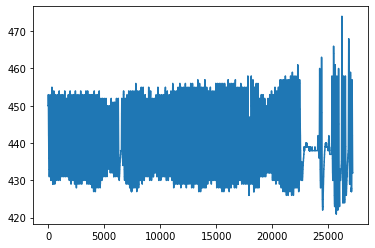

In [70]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse

ppg_simulated=pd.read_csv('/content/drive/MyDrive/CNN-TESIS/RAW-DATA-TEKANAN-DARAH/RAW/p001.csv')
plt.plot(ppg_simulated)
plt.show()

time domain analyze

In [71]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [72]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [73]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

In [74]:
P114=pd.read_csv('/content/drive/MyDrive/CNN-TESIS/RAW-DATA-TEKANAN-DARAH/RAW/p001.csv',  header=None)
ppg_and_ecg=np.array(P114)

In [75]:
ppg = P114[0]

In [76]:
ppg.ndim

1

In [77]:
ppg.head()

0    449.00
1    450.00
2    450.00
3    450.00
4    450.96
Name: 0, dtype: float64

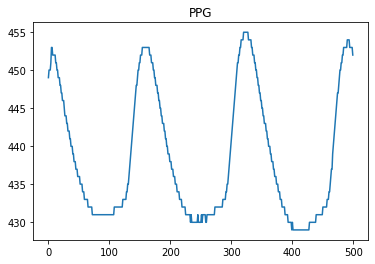

In [78]:
plt.plot(ppg_and_ecg[0:500])
plt.title("PPG", color = "black")
plt.tick_params(axis="both", colors = "black")

--------------------------------------------------- alternatif-----------------------------------

In [79]:
long = len(ppg)
long
long1 = long-1
long1

27199

posisi titik puncak : [5.0000e+00 1.5900e+02 3.2300e+02 4.9100e+02 6.5000e+02 8.0900e+02
 9.7700e+02 1.1390e+03 1.3000e+03 1.4710e+03 1.6310e+03 1.7890e+03
 1.9490e+03 2.1080e+03 2.2610e+03 2.4210e+03 2.5800e+03 2.7340e+03
 2.8940e+03 3.0580e+03 3.2120e+03 3.3670e+03 3.5190e+03 3.6720e+03
 3.8190e+03 3.9630e+03 4.1080e+03 4.2570e+03 4.4010e+03 4.5510e+03
 4.7060e+03 4.8560e+03 5.0080e+03 5.1620e+03 5.3170e+03 5.4690e+03
 5.6220e+03 5.7800e+03 5.9400e+03 6.0940e+03 6.2500e+03 6.5680e+03
 6.7260e+03 6.8820e+03 7.0360e+03 7.1880e+03 7.3440e+03 7.5050e+03
 7.6580e+03 7.8200e+03 7.9830e+03 8.1450e+03 8.3060e+03 8.4770e+03
 8.6470e+03 8.8080e+03 8.9730e+03 9.1400e+03 9.3090e+03 9.4690e+03
 9.6310e+03 9.7960e+03 9.9650e+03 1.0129e+04 1.0292e+04 1.0462e+04
 1.0631e+04 1.0799e+04 1.0960e+04 1.1123e+04 1.1284e+04 1.1445e+04
 1.1601e+04 1.1760e+04 1.1924e+04 1.2084e+04 1.2247e+04 1.2410e+04
 1.2568e+04 1.2727e+04 1.2888e+04 1.3049e+04 1.3204e+04 1.3361e+04
 1.3518e+04 1.3676e+04 1.3832e+04 1.3994

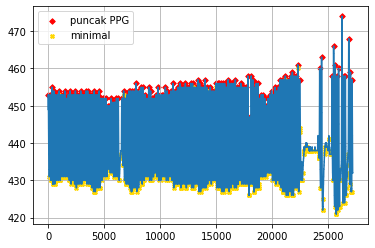

In [80]:
# x and y definition
x= np.linspace(0,long1,long) 
y= ppg

#find peak
peaks = find_peaks(y, height=445, threshold=0, distance=10)
height = peaks[1]['peak_heights']
peak_post= x[peaks[0]]

  
print("posisi titik puncak :", peak_post)


#menemukan nilai minimum
y2=y*-1
minima=find_peaks(y2)
min_pos=x[minima[0]]
min_height=y2[minima[0]]

#print titik puncak
peak_coordinate=peak_post
    #print(peak_coordinate)
#banyaknya puncak
    # print(len(peak_coordinate)) 
    #output 40
#data titik ke2 sampai 40
data1=peak_coordinate[1:]
#data titik ke1-39
data2=peak_coordinate[:-1]
#jarak antar puncak (pengurangan array)
distance= data1-data2
#mencari rata-rata jarak
total = np.sum(distance)
totaldistance = total
average= totaldistance/len(distance)
#pengolahan data delay 10
# RR = 10*average
# HR= 60000/RR

#pengolahan data delay 05
RR=average*5
HR=60000/RR

#print(min(peak_post))
print("----------------------------------------------------------------------")
print("jarak antar puncak :", distance)   #selisih
print("----------------------------------------------------------------------")
print("jarak terdekat :", min(distance))
print("----------------------------------------------------------------------")
print("jarak terjauh :", max(distance))
print("----------------------------------------------------------------------")
print("rata-rata jarak :", average)
print("----------------------------------------------------------------------")
print("banyaknya peak :", len(distance))
print("----------------------------------------------------------------------")
print("jumlah jarak:", total)
print("----------------------------------------------------------------------")
print("HR", HR)

#plotting
fig = plt.figure()
ax= fig.subplots()
ax.plot(x,y)
ax.scatter(peak_post, height, color='r', s=15, marker='D', label='puncak PPG')
ax.scatter(min_pos, min_height*-1, color='gold', s=15, marker='X', label='minimal')
ax.legend()
ax.grid()
plt.show()

In [81]:
diff_sig_2=np.diff(ppg_and_ecg[1])

In [82]:
diff_sig_2.ndim

1

In [83]:
# HR will probably not go below 30 bpm : distance=500*(30/60))
# prominence found experimentally
peaks_2, _ = find_peaks(diff_sig_2, distance=50*(30/60), prominence=0.001)
peaks_2

array([], dtype=int64)

IndexError: ignored

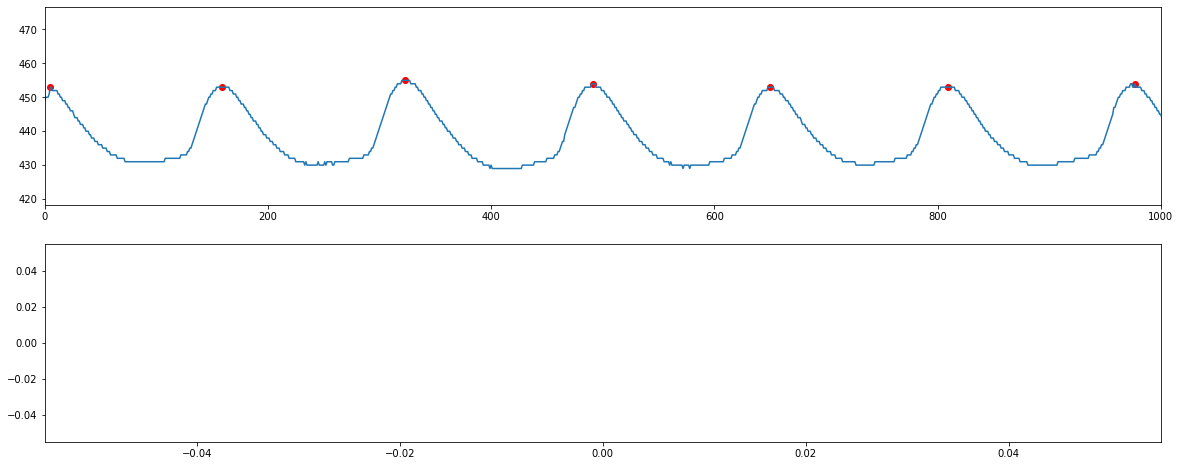

In [84]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(ppg_and_ecg)
plt.scatter(peak_post, ppg [peak_post], color="red")
plt.gca().set_xlim(0, 1000)
plt.subplot(2,1,2)
plt.plot(diff_sig_2)
plt.scatter(peak_post, diff_sig_2[peak_post], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [85]:
rr_2 = np.diff(peak_post)
corr_rr_2 = rr_2*10

In [86]:
corr_rr_2

array([ 1540.,  1640.,  1680.,  1590.,  1590.,  1680.,  1620.,  1610.,
        1710.,  1600.,  1580.,  1600.,  1590.,  1530.,  1600.,  1590.,
        1540.,  1600.,  1640.,  1540.,  1550.,  1520.,  1530.,  1470.,
        1440.,  1450.,  1490.,  1440.,  1500.,  1550.,  1500.,  1520.,
        1540.,  1550.,  1520.,  1530.,  1580.,  1600.,  1540.,  1560.,
        3180.,  1580.,  1560.,  1540.,  1520.,  1560.,  1610.,  1530.,
        1620.,  1630.,  1620.,  1610.,  1710.,  1700.,  1610.,  1650.,
        1670.,  1690.,  1600.,  1620.,  1650.,  1690.,  1640.,  1630.,
        1700.,  1690.,  1680.,  1610.,  1630.,  1610.,  1610.,  1560.,
        1590.,  1640.,  1600.,  1630.,  1630.,  1580.,  1590.,  1610.,
        1610.,  1550.,  1570.,  1570.,  1580.,  1560.,  1620.,  1640.,
        1590.,  1650.,  1630.,  1600.,  1650.,  1530.,  1580.,  1540.,
        1590.,  1620.,  1560.,  1580.,  1630.,  1600.,  1570.,  1640.,
        1660.,  1590.,  1600.,  1600.,  1600.,  1560.,  1570.,  1720.,
      

In [87]:
timedomain(corr_rr_2)

{'Max HR (beats/min)': 45.80152671755725,
 "Mean HR (Kubios' style) (beats/min)": 34.03941794068889,
 'Mean HR (beats/min)': 37.30773745028567,
 'Mean RR (ms)': 1762.6623376623377,
 'Min HR (beats/min)': 3.3557046979865772,
 'NNxx': 45,
 'RMSSD (ms)': 2075.833559638215,
 'STD HR (beats/min)': 4.786131100268698,
 'STD RR/SDNN (ms)': 1458.5409192946465,
 'pNNxx (%)': 29.22077922077922}

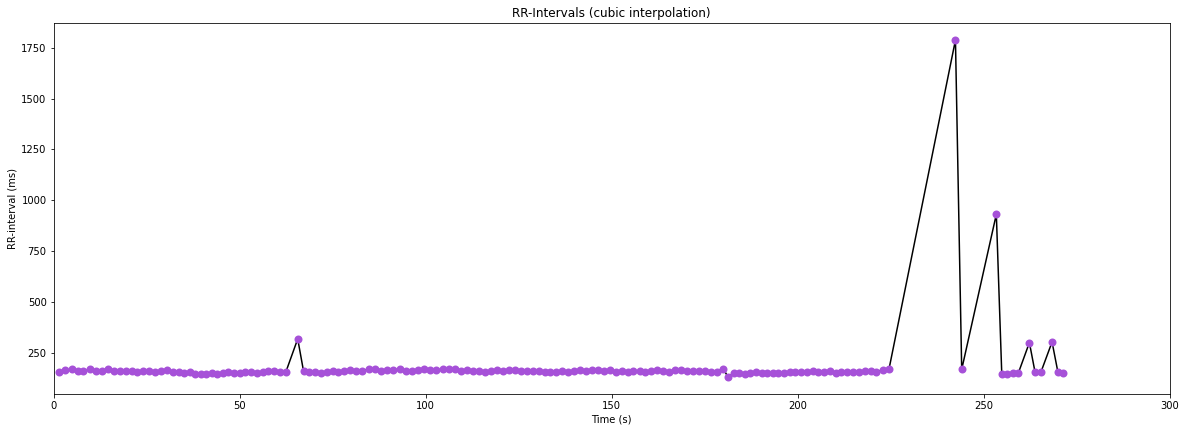

In [88]:
x_2 = np.cumsum(rr_2)/ 100.0
f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx_2 = np.arange(1, np.max(x_2), steps)

rr_interpolated = f_2(xx_2)

plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x_2, rr_2, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 300)

#plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
#plt.plot(xx_2, rr_interpolated_2, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 300)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [89]:
print("Frequency domain metrics:")
results_2, fxx_2, pxx_2 = frequency_domain(rr_interpolated)

for k, v in results_2.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 161700.51
- Power LF (ms2): 36768.82
- Power HF (ms2): 118.28
- Power Total (ms2): 198587.61
- LF/HF: 310.85
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.16
- Fraction LF (nu): 99.68
- Fraction HF (nu): 0.32


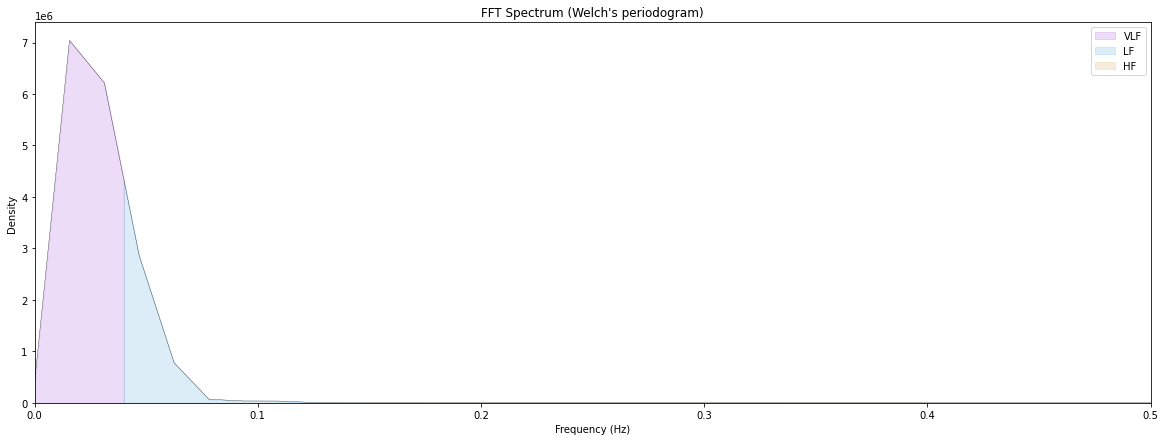

In [90]:
plt.figure(figsize=(20, 7))
plt.plot(fxx_2, pxx_2, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx_2, pxx_2)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

SD1: 146.784 ms
SD2: 145.846 ms


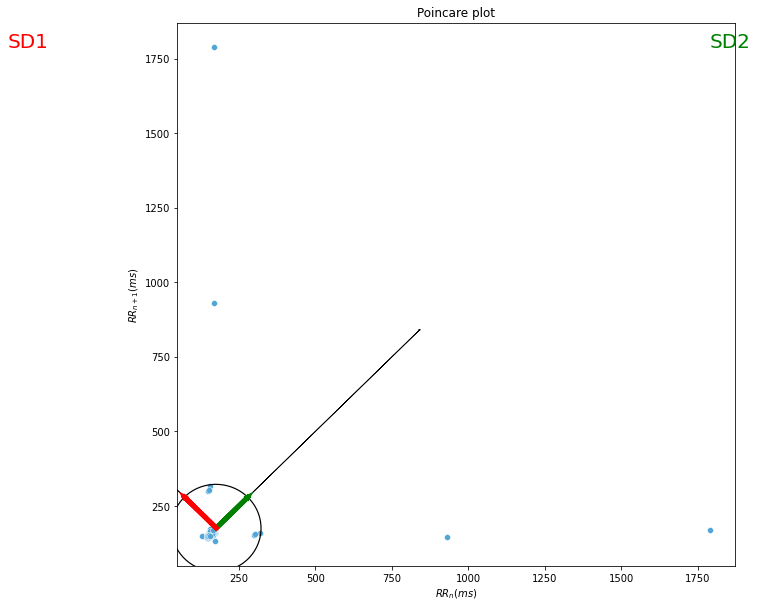

In [91]:
import seaborn as sns
from matplotlib.patches import Ellipse
sd1_2, sd2_2 = plot_poincare(rr_2)
print("SD1: %.3f ms" % sd1_2)
print("SD2: %.3f ms" % sd2_2)

In [92]:
ecg_signals, info  = nk.ecg_process(ppg, sampling_rate=100)

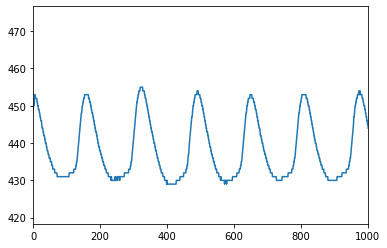

In [93]:
plt.plot(ppg)
plt.scatter(info['ECG_R_Peaks'], ppg[info['ECG_R_Peaks']], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [94]:
rr_ecg = np.diff(info['ECG_R_Peaks'])
corr_rr_ecg = rr_ecg*10

In [95]:
!pip install hrv-analysis

In [96]:
!pip install pyhrv

In [97]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

In [98]:
rr_intervals_list = info['ECG_R_Peaks']

In [99]:
import pyhrv.tools as tools

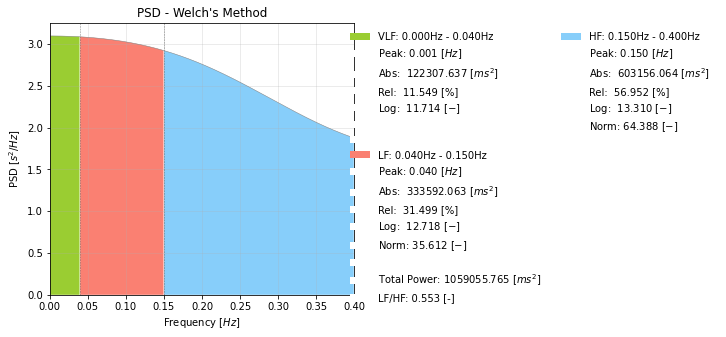

(0.0009765625, 0.0400390625, 0.150390625)


In [100]:
import pyhrv.frequency_domain as fd
nni = tools.nn_intervals(rr_intervals_list)
result = fd.welch_psd(nni=nni)
# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])

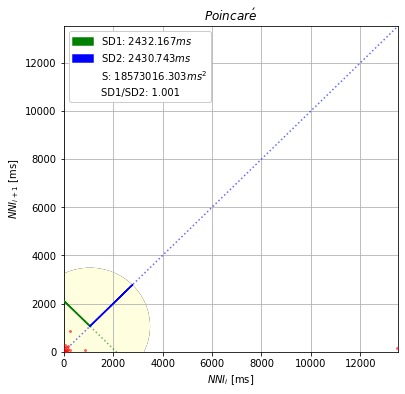

2432.167400757218


In [101]:
import pyhrv.nonlinear as nl
result = nl.poincare(nni)
print(result['sd1'])

In [102]:
result = nl.sample_entropy(nni)
print(result['sampen'])

0.1823215567939546


- Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lesspinasse, F., Pham, H., Schölzel, C., & S H Chen, A. (2020). NeuroKit2: A Python Toolbox for Neurophysiological Signal Processing. Retrieved May 07, 2020, from https://github.com/neuropsychology/NeuroKit
- https://www.kaggle.com/stetelepta/exploring-heart-rate-variability-using-python